## EDA 
Iniciamos con el ánalisis exploratorio de los datos donde vamos a conocer como se comportan los datos, de esta manera optener las columnas mas relevantes para poder realizar nuestro sistema de recomendación

In [54]:
# Importamos las librerias que vamos a utilizar 
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import json
from pandas import json_normalize
import re
import matplotlib.pyplot as plt
import requests
import ast
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from sklearn.cluster import KMeans
from scipy.sparse import hstack
from sklearn.metrics.pairwise import cosine_similarity
sns.set_theme()

In [9]:
# Importamos los dos archivos para realizar una concatenación dejando la mayora de los datos para el án analisis
df_credits = pd.read_parquet('../Data/credits_final.parquet', engine='fastparquet')
df_movies2 = pd.read_parquet('../Data/movies_dataset_f.parquet', engine='fastparquet')

In [10]:
# Unimos los dos dataset para iniciar nuestro ánalisis
df_movies2['id'] = df_movies2['id'].astype(int)
df_Union2 = pd.merge(df_credits, df_movies2, on='id', how='inner')

## Inicio
Iniciamos revisando el dataframe para saber que columnas podemos utilizar

In [11]:
# Informacion global de nuestro dataset 
# Podemos notar que tenemos muchoas columnnas con valores faltantes
df_Union2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45451 entries, 0 to 45450
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   cas_actor1         43097 non-null  object        
 1   cas_actor2         41768 non-null  object        
 2   cas_actor3         40858 non-null  object        
 3   cas_actor4         39726 non-null  object        
 4   cas_actor5         37248 non-null  object        
 5   cas_actor6         34564 non-null  object        
 6   cas_actor7         31872 non-null  object        
 7   cas_actor8         29113 non-null  object        
 8   cas_actor9         26343 non-null  object        
 9   cas_actor10        23749 non-null  object        
 10  crew_Director      44616 non-null  object        
 11  id                 45451 non-null  int64         
 12  iso_639_1          41677 non-null  object        
 13  name               39232 non-null  object        
 14  iso_31

In [12]:
# Contamos los valoes de 0 
conteo = 0
for i in range(0, len(df_Union2)):
    if df_Union2['budget'][i] == 0:
        conteo += 1
print('Con una cantidad de 45451 contamos con ', conteo , ' que son nulos es un promedio muy alto de valores no existentes')

Con una cantidad de 45451 contamos con  36543  que son nulos es un promedio muy alto de valores no existentes


In [13]:
# Contamos los valoes de 0 
conteo = 0
for i in range(0, len(df_Union2)):
    if df_Union2['revenue'][i] == 0:
        conteo += 1
print('Con una cantidad de 45451 contamos con ', conteo , ' que son nulos es un promedio muy alto de valores no existentes')

Con una cantidad de 45451 contamos con  38024  que son nulos es un promedio muy alto de valores no existentes


In [14]:
# Borramos las columnas que consideramos que nos ofrecen muy poca información para nuestro sistema de recomendación
df_UnionF = df_Union2.drop(['revenue', 'budget', 'return', 'genres_id', 'genres_id1', 'genres_id2', 'collection_id', 'iso_639_1', 'name', 'iso_3166_1', 'companies_id', 'runtime', 'original_language', 'overview'], axis=1)

In [15]:
df_UnionF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45451 entries, 0 to 45450
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   cas_actor1       43097 non-null  object        
 1   cas_actor2       41768 non-null  object        
 2   cas_actor3       40858 non-null  object        
 3   cas_actor4       39726 non-null  object        
 4   cas_actor5       37248 non-null  object        
 5   cas_actor6       34564 non-null  object        
 6   cas_actor7       31872 non-null  object        
 7   cas_actor8       29113 non-null  object        
 8   cas_actor9       26343 non-null  object        
 9   cas_actor10      23749 non-null  object        
 10  crew_Director    44616 non-null  object        
 11  id               45451 non-null  int64         
 12  companies_name   33634 non-null  object        
 13  genres_name      45451 non-null  object        
 14  genres_name1     45451 non-null  objec

In [16]:
df_UnionF.describe()

,id,popularity,release_date,vote_average,vote_count,release_year
count,45451.000000,45451.000000,45451,45451.000000,45451.000000,45451.000000
mean,107984.599745,2.926887,1992-05-16 00:18:33.955688576,5.624085,109.989703,1991.882027
min,2.000000,0.000000,1874-12-09 00:00:00,0.000000,0.000000,1874.000000
25%,26367.500000,0.389095,1978-10-08 00:00:00,5.000000,3.000000,1978.000000
50%,59871.000000,1.131386,2001-09-01 00:00:00,6.000000,10.000000,2001.000000
75%,156327.500000,3.694370,2010-12-16 00:00:00,6.800000,34.000000,2010.000000
max,469172.000000,547.488298,2020-12-16 00:00:00,10.000000,14075.000000,2020.000000
std,112111.336735,6.006458,NaN,1.915424,491.352336,24.057726


## Ánalisis de graficos

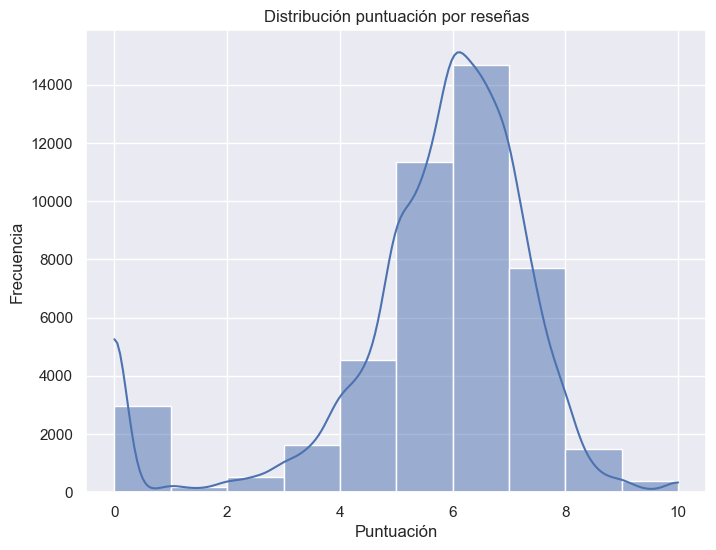

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(df_UnionF['vote_average'], bins=10, kde=True)
plt.title('Distribución puntuación por reseñas')
plt.xlabel('Puntuación')
plt.ylabel('Frecuencia')
plt.show()

En el pasado grafico podemos ver como que la puntuación a las peliculas esta en su mayor parte entre los 4 y 8 puntos

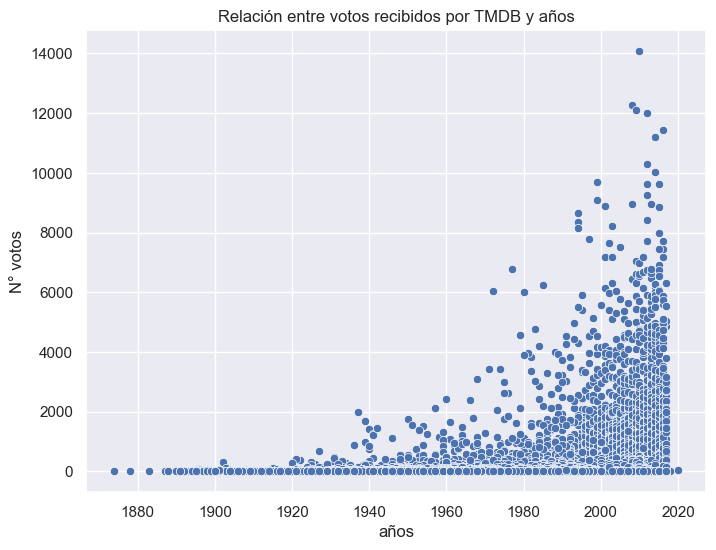

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='release_year', y='vote_count', data=df_UnionF)
plt.title('Relación entre votos recibidos por TMDB y años')
plt.xlabel('años')
plt.ylabel('N° votos')
plt.show()

Por medio de este grafico podemos concluir que los valores der vote_count no son outliers sino que las botaciones por parte de TMBD han sido mayores en los ultimos años en comparación de los primeros años donde se obtubo calificaciones muy bajas

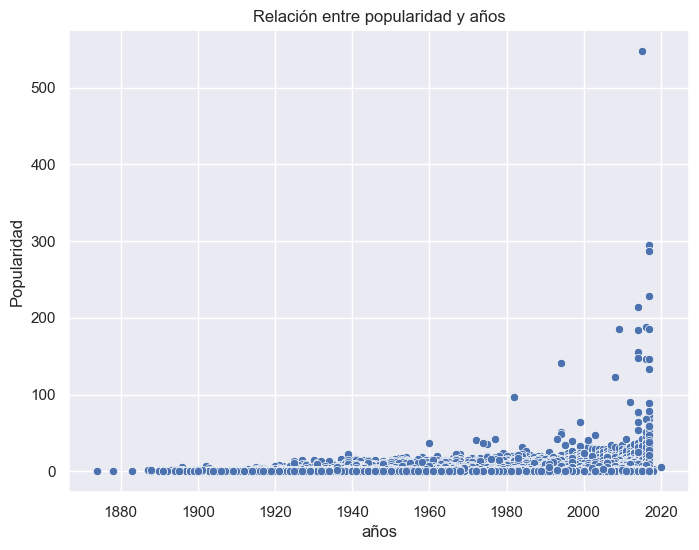

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='release_year', y='popularity', data=df_UnionF)
plt.title('Relación entre popularidad y años')
plt.xlabel('años')
plt.ylabel('Popularidad')
plt.show()

En el anterior grafico podemos ver que al pasar los años por alguna razón su popularidad se va ingrementando, pero como podemos darnos de cuenta contamos con un valor que es mucho mas grande y se encuantra muy alejado, este valor podria ser un error o la pelicula con mayor popularidad, al analizar los datos si procedemos a remplazar este valor no afecta para nada la media.

In [21]:
df = df_UnionF[['popularity', 'vote_count', 'vote_average']]

In [22]:
correlation_matrix = df.corr()

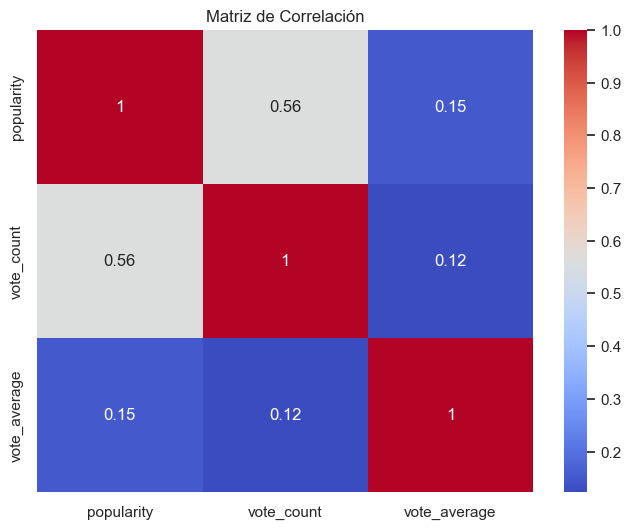

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

En el anterior grafico podemos concluir que exinten dos variables que tiene  gran correlación las cuales son popularity y vote_count, su correlación es positiva

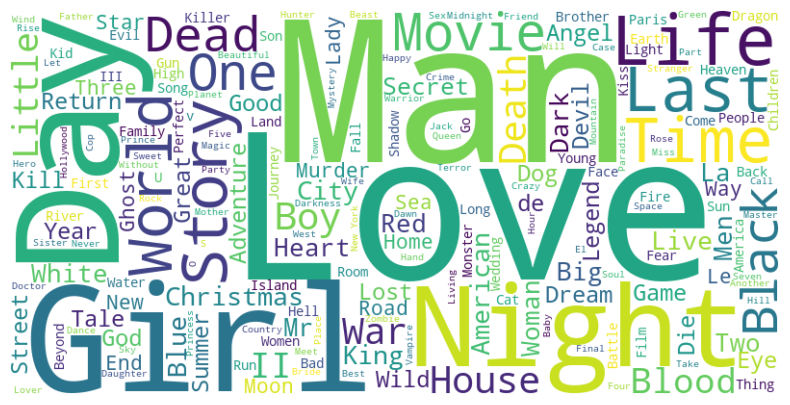

In [24]:
# Combinar todos los títulos en un solo string
text = " ".join(titulo for titulo in df_UnionF['title'])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No mostrar los ejes
plt.show()

Palabras que son mas relevantes entre todas las peliculas 